# 08/24 updates

In [1]:
import pandas as pd
Performance_df={}
Performance_df['model_type']=["Cat-Boosting","Graph Structure 1","Graph Structure 2"]
Performance_df["Total_Observation"]=[2566850]*3
Performance_df["True_Prediction"]=[1902677,2129214,2125086]
Performance_df["False_Prediction"]=[664173,437636,441764]
Performance_df["accuracy"]=[0.7412,0.8295,0.8279]
Performance_df["precision"]=[0.4845,0.7078,0.6934]
Performance_df["recall"]=[0.8245,0.5218,0.5375]
Performance_df["F1_score"]=[0.6104,0.6008,0.6056]
Performance_df["ROC_AUC"]=[0.8568,0.8820,0.8810]
Performance_df["PR_AUC"]=[0.6469,0.7008,0.6960]
pd.DataFrame(Performance_df).set_index("model_type").style.format({"Total_Observation":"{:,}","True_Prediction":"{:,}","False_Prediction":"{:,}",\
                                         "accuracy":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","ROC_AUC":"{:.2%}","PR_AUC":"{:.2%}"})

,Total_Observation,True_Prediction,False_Prediction,accuracy,precision,recall,F1_score,ROC_AUC,PR_AUC
model_type,,,,,,,,,
Cat-Boosting,"2,566,850","1,902,677","664,173",74.12%,48.45%,82.45%,0.6104,85.68%,64.69%
Graph Structure 1,"2,566,850","2,129,214","437,636",82.95%,70.78%,52.18%,0.6008,88.20%,70.08%
Graph Structure 2,"2,566,850","2,125,086","441,764",82.79%,69.34%,53.75%,0.6056,88.10%,69.60%


#### Graph Structure V1

<img src="CAP_Graph_Structure_v1.PNG" alt="drawing" width="500"/>

#### Graph Structure V2

<img src="CAP_Graph_Structure_v2.PNG" alt="drawing" width="500"/>

In [4]:
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
RGCN_v1_logits = load("Conv_LOGIT.npz")['arr_0']
RGCN_v1_targets = load("Conv_LABEL.npz")['arr_0']
RGCN_v2_logits = load("Conv_LOGIT_v2.npz")['arr_0']
RGCN_v2_targets = load("Conv_LABEL_v2.npz")['arr_0']
Catboost_logits = load("Catboost_LOGIT.npz")['arr_0']
Catboost_targets = load("Catboost_LABEL.npz")['arr_0']

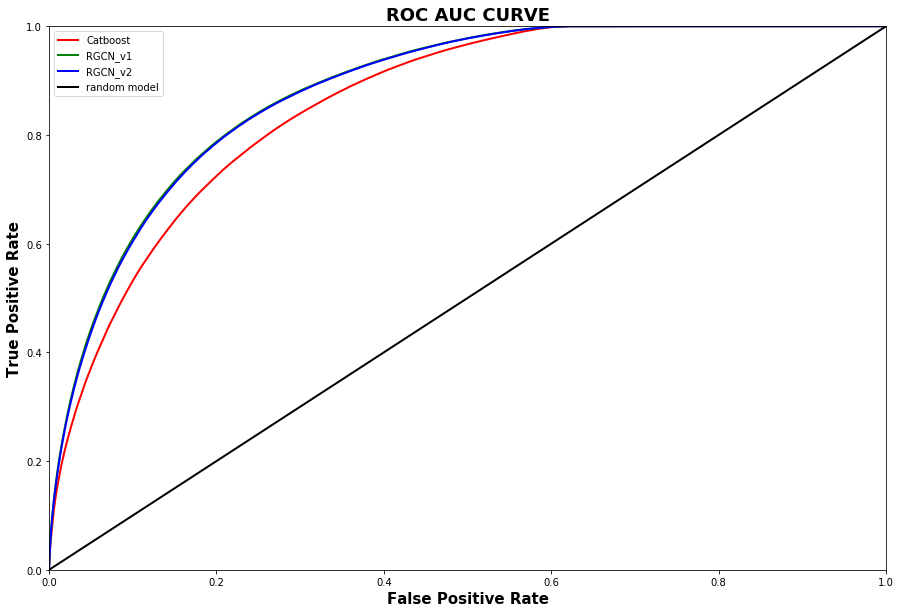

In [5]:
# calculate roc curves
from sklearn.metrics import roc_curve
from numpy import save, load,savetxt, loadtxt, savez_compressed
import matplotlib.pyplot as plt

fpr_RGCN_v1, tpr_RGCN_v1, _ = roc_curve(RGCN_v1_targets,  RGCN_v1_logits[:,1])

fpr_RGCN_v2, tpr_RGCN_v2, _ = roc_curve(RGCN_v2_targets,  RGCN_v2_logits[:,1])

fpr_Catboost, tpr_Catboost, _ = roc_curve(Catboost_targets,  Catboost_logits[:,1])

# plot the roc curve for the model
fig = plt.subplots(figsize =(15, 10))
plt.plot(fpr_Catboost, tpr_Catboost, linestyle='solid', label='Catboost', color ='r', linewidth=2)
plt.plot(fpr_RGCN_v1, tpr_RGCN_v1, linestyle='solid', label='RGCN_v1', color ='g', linewidth=2)
plt.plot(fpr_RGCN_v2, tpr_RGCN_v2, linestyle='solid', label='RGCN_v2', color ='b', linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='solid', label='random model', color ='black', linewidth=2)
# axis labels
plt.xlabel('False Positive Rate', fontweight ='bold',fontsize=15)
plt.ylabel('True Positive Rate', fontweight ='bold',fontsize=15)
plt.title('ROC AUC CURVE', fontweight ='bold',fontsize=18)

plt.xlim([0, 1])
plt.ylim([0, 1])
# show the legend
plt.legend(fontsize="medium")
# show the plot
plt.show()

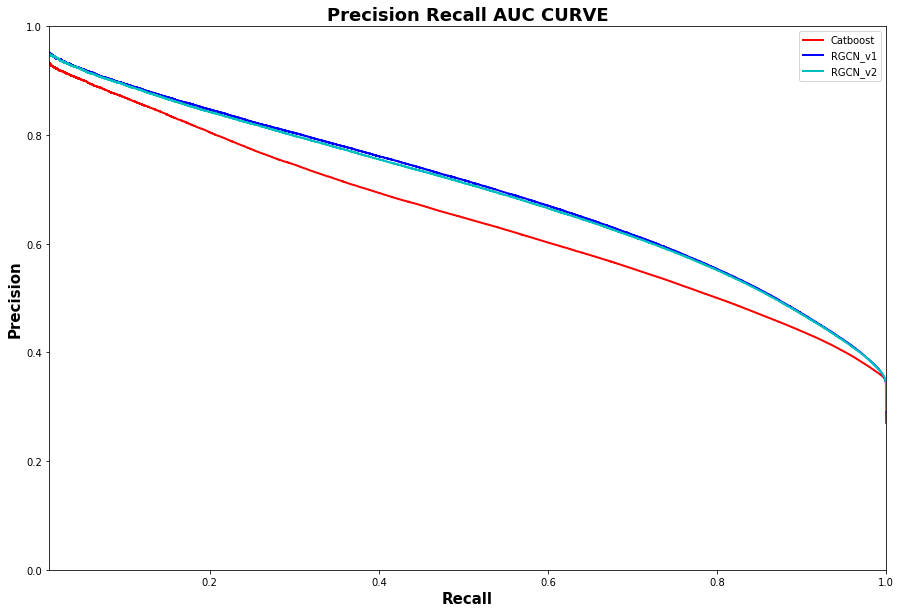

In [6]:
# calculate precision-recall curves
from sklearn.metrics import precision_recall_curve
from numpy import save, load,savetxt, loadtxt, savez_compressed
import matplotlib.pyplot as plt

prec_RGCN_v1, recall_RGCN_v1, _ = precision_recall_curve(RGCN_v1_targets,  RGCN_v1_logits[:,1])
prec_RGCN_v2, recall_RGCN_v2, _ = precision_recall_curve(RGCN_v2_targets,  RGCN_v2_logits[:,1])
prec_Catboost, recall_Catboost, _ = precision_recall_curve(Catboost_targets,  Catboost_logits[:,1])

fig = plt.subplots(figsize =(15, 10))

plt.plot(recall_Catboost, prec_Catboost, linestyle='solid', label='Catboost', color ='r', linewidth=2)
plt.plot(recall_RGCN_v1, prec_RGCN_v1, linestyle='solid', label='RGCN_v1', color ='b', linewidth=2)
plt.plot(recall_RGCN_v2, prec_RGCN_v2, linestyle='solid', label='RGCN_v2', color ='c', linewidth=2)

# plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='random model', color ='black', linewidth=2)

# axis labels
plt.xlabel('Recall', fontweight ='bold',fontsize=15)
plt.ylabel('Precision', fontweight ='bold',fontsize=15)
plt.title('Precision Recall AUC CURVE', fontweight ='bold',fontsize=18)

plt.xlim([0.01, 1])
plt.ylim([0, 1])
# show the legend
plt.legend(fontsize="medium")
# show the plot
plt.show()

#### Response Rate

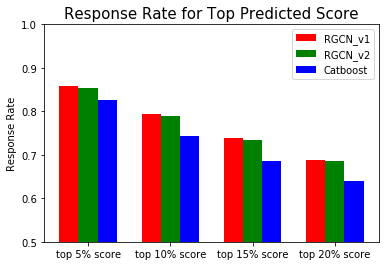

In [7]:
import math
def response_rate_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    response_rate={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        response_rate[str(int(p*100))+"%"]=DF2.actual_label.sum()/DF2.shape[0]
    return response_rate

topk=[0.05,0.1,0.15,0.2]
response_RGCN_v1 = response_rate_eval(RGCN_v1_logits[:,1], RGCN_v1_targets, topk)
response_RGCN_v2 = response_rate_eval(RGCN_v2_logits[:,1], RGCN_v2_targets, topk)
response_Catboost = response_rate_eval(Catboost_logits[:,1], Catboost_targets, topk)


Decile=list(response_RGCN_v1.keys())

response_RGCN_v1=[response_RGCN_v1[x] for x in Decile]
response_RGCN_v2=[response_RGCN_v2[x] for x in Decile]
response_Catboost=[response_Catboost[x] for x in Decile]


from matplotlib import pyplot as plt


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

    ax.set_ylabel('Response Rate')
    ind=np.arange(len(data[list(data.keys())[0]]))
    ax.set_xticks(ind)
    ax.set_xticklabels( ('top 5% score', 'top 10% score', 'top 15% score', 'top 20% score') )
    ax.set_title("Response Rate for Top Predicted Score",fontsize=15)


if __name__ == "__main__":
    # Usage example:
    data = {
        "RGCN_v1": response_RGCN_v1,
        "RGCN_v2": response_RGCN_v2,
        "Catboost": response_Catboost
    }

    fig, ax = plt.subplots()
    CL=['r', 'g', 'b', 'c', 'y', 'darkorange', 'lime', 'grey','gold','bisque', 'lightseagreen', 'purple']
    bar_plot(ax, data, colors=CL,total_width=.7, single_width=1)
    # plt.xlim([0, 1])
    plt.ylim([0.5, 1])
    plt.show()

In [8]:
Response_Rate={}
Response_Rate["Method"]=["RGCN_v1", "RGCN_v2","Catboost"]
Response_Rate["top 5% score"]=[response_RGCN_v1[0],response_RGCN_v2[0],response_Catboost[0]]
Response_Rate["top 10% score"]=[response_RGCN_v1[1],response_RGCN_v2[1],response_Catboost[1]]
Response_Rate["top 15% score"]=[response_RGCN_v1[2],response_RGCN_v2[2],response_Catboost[2]]
Response_Rate["top 20% score"]=[response_RGCN_v1[3],response_RGCN_v2[3],response_Catboost[3]]

Response_Rate=pd.DataFrame(Response_Rate)
Response_Rate.style.format({"top 5% score":"{:.2%}","top 10% score":"{:.2%}","top 15% score":"{:.2%}","top 20% score":"{:.2%}"})


,Method,top 5% score,top 10% score,top 15% score,top 20% score
0,RGCN_v1,85.85%,79.38%,73.89%,68.90%
1,RGCN_v2,85.42%,78.94%,73.45%,68.57%
2,Catboost,82.56%,74.40%,68.48%,63.90%


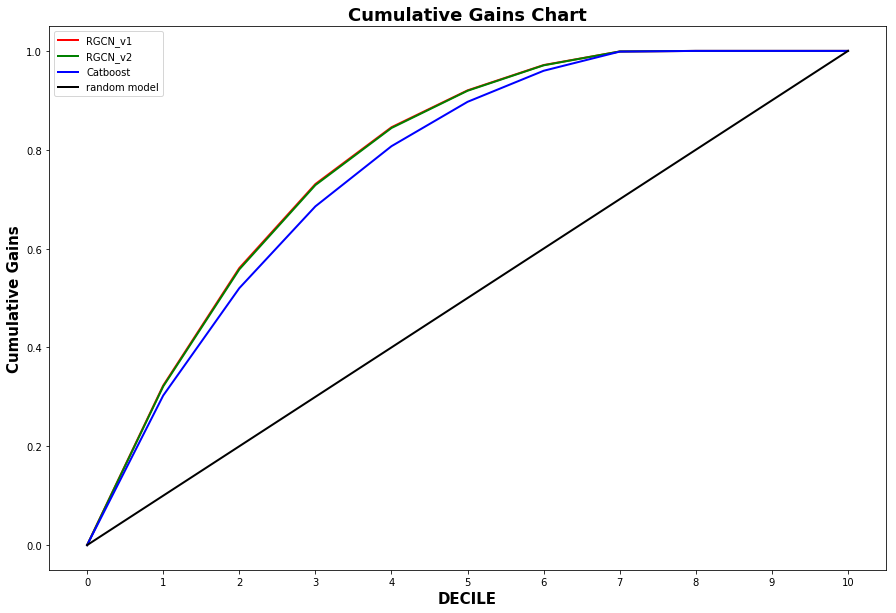

In [9]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=DF2.actual_label.sum()/DF.actual_label.sum()
    return gain

topk=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
gain_RGCN_v1 = lift_gain_eval(RGCN_v1_logits[:,1], RGCN_v1_targets, topk)
gain_RGCN_v2 = lift_gain_eval(RGCN_v2_logits[:,1], RGCN_v2_targets, topk)
gain_Catboost = lift_gain_eval(Catboost_logits[:,1], Catboost_targets, topk)

Decile=list(gain_RGCN_v1.keys())

gain_RGCN_v1=[gain_RGCN_v1[x] for x in Decile]
gain_RGCN_v2=[gain_RGCN_v2[x] for x in Decile]
gain_Catboost=[gain_Catboost[x] for x in Decile]

gain_RGCN_v1.insert(0,0)
gain_RGCN_v2.insert(0,0)
gain_Catboost.insert(0,0)

Decile=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
# plot the roc curve for the model
fig = plt.subplots(figsize =(15, 10))
plt.plot(Decile, gain_RGCN_v1, linestyle='solid', label='RGCN_v1', color ='r', linewidth=2)
plt.plot(Decile, gain_RGCN_v2, linestyle='solid', label='RGCN_v2', color ='g', linewidth=2)
plt.plot(Decile, gain_Catboost, linestyle='solid', label='Catboost', color ='b', linewidth=2)

plt.plot([0, 10], [0, 1], linestyle='solid', label='random model', color ='black', linewidth=2)
# axis labels
plt.xlabel('DECILE', fontweight ='bold',fontsize=15)
plt.ylabel('Cumulative Gains', fontweight ='bold',fontsize=15)
plt.title('Cumulative Gains Chart', fontweight ='bold',fontsize=18)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10])
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# show the legend
plt.legend(fontsize="medium")
# show the plot
plt.show()

### Inductive Learning Based on connected component of Family Units

<img src="CAP_Graph_Structure_v1.PNG" alt="drawing" width="500"/>

### Distribution of Connected Component (Family Units)

In [186]:
import pandas as pd
import numpy as np
from numpy import save, load, savetxt, loadtxt, savez_compressed
import matplotlib.pyplot as plt
labels=load("CCP_Label.npz")['arr_0']

In [11]:
np.random.seed(123)
component=np.unique(labels)
train_component=np.random.choice(component,size=int(0.8*component.shape[0]),replace=False)
val_test_component=np.setdiff1d(component,train_component)
val_component=np.random.choice(val_test_component,size=int(0.5*val_test_component.shape[0]),replace=False)
test_component=np.setdiff1d(val_test_component,val_component)

df={}
df["data"]=["Training Set", "Validation Set", "Test Set", "Total"]
df["# of family unit"]=[train_component.shape[0],val_component.shape[0],test_component.shape[0],component.shape[0]]
df["% of family unit"]=[train_component.shape[0]/component.shape[0],val_component.shape[0]/component.shape[0],\
                        test_component.shape[0]/component.shape[0],component.shape[0]/component.shape[0]]

pd.DataFrame(df).style.format({"# of family unit":"{:,}","% of family unit":"{:.0%}"})

,data,# of family unit,% of family unit
0,Training Set,"4,910,614",80%
1,Validation Set,"613,827",10%
2,Test Set,"613,827",10%
3,Total,"6,138,268",100%


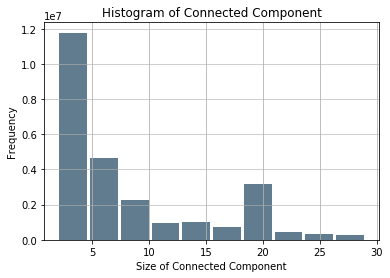

In [12]:
_,num_inverse,num_count=np.unique(labels,return_inverse=True, return_counts=True)
data_CCP=pd.DataFrame([num_count[i] for i in num_inverse],columns=["size"])
data_CCP['size']=data_CCP['size'].apply(lambda x: 20 if x>=30 else x)
data_CCP.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607C8E',legend=None)
plt.title('Histogram of Connected Component')
plt.xlabel('Size of Connected Component')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [13]:
_,train_num_inverse,train_num_count=np.unique(labels[train_component],return_inverse=True, return_counts=True)
train_CCP=pd.DataFrame([train_num_count[i] for i in train_num_inverse],columns=["size"])
train_CCP['size']=train_CCP['size'].apply(lambda x: 20 if x>=30 else x)

_,val_num_inverse,val_num_count=np.unique(labels[val_component],return_inverse=True, return_counts=True)
val_CCP=pd.DataFrame([val_num_count[i] for i in val_num_inverse],columns=["size"])
val_CCP['size']=val_CCP['size'].apply(lambda x: 20 if x>=30 else x)

_,test_num_inverse,test_num_count=np.unique(labels[test_component],return_inverse=True, return_counts=True)
test_CCP=pd.DataFrame([test_num_count[i] for i in test_num_inverse],columns=["size"])
test_CCP['size']=test_CCP['size'].apply(lambda x: 20 if x>=30 else x)

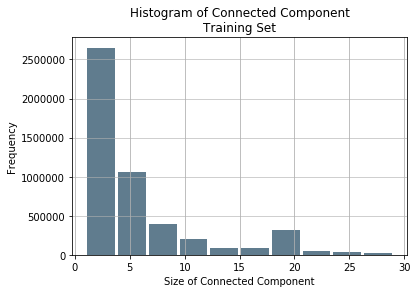

In [14]:
# plt.subplot(1, 2, 1)
train_CCP.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607C8E',legend=None)
plt.title('Histogram of Connected Component\nTraining Set')
plt.xlabel('Size of Connected Component')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

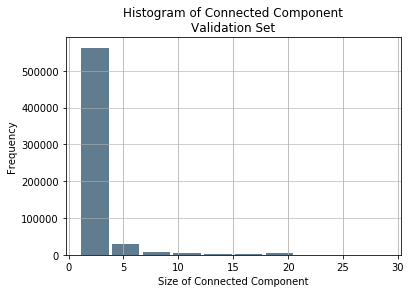

In [15]:
# plt.subplot(1,2,2)
val_CCP.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607C8E',legend=None)
plt.title('Histogram of Connected Component\nValidation Set')
plt.xlabel('Size of Connected Component')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

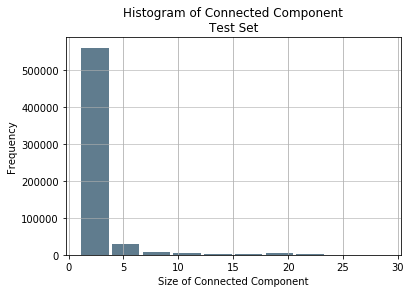

In [16]:
# plt.subplot(1,2,2)
test_CCP.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607C8E',legend=None)
plt.title('Histogram of Connected Component\nTest Set')
plt.xlabel('Size of Connected Component')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [17]:
import pandas as pd
Performance_df={}
Performance_df['model_type']=["Cat-Boosting","Graph Neural Network"]
Performance_df["Total_Observation"]=[205192389]*2
Performance_df["True_Prediction"]=[15203996,16965683]
Performance_df["False_Prediction"]=[5315242,3553555]
Performance_df["accuracy"]=[0.7409,0.8268]
Performance_df["precision"]=[0.4841,0.6774]
Performance_df["recall"]=[0.8233,0.5637]
Performance_df["F1_score"]=[0.6097,0.6154]
Performance_df["ROC_AUC"]=[0.8561,0.8799]
Performance_df["PR_AUC"]=[0.6463,0.6940]
print()
print()
print("Training Set")
print()
pd.DataFrame(Performance_df).style.format({"Total_Observation":"{:,}","True_Prediction":"{:,}","False_Prediction":"{:,}",\
                                         "accuracy":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","ROC_AUC":"{:.2%}","PR_AUC":"{:.2%}"})



Training Set



,model_type,Total_Observation,True_Prediction,False_Prediction,accuracy,precision,recall,F1_score,ROC_AUC,PR_AUC
0,Cat-Boosting,"205,192,389","15,203,996","5,315,242",74.09%,48.41%,82.33%,0.6097,85.61%,64.63%
1,Graph Neural Network,"205,192,389","16,965,683","3,553,555",82.68%,67.74%,56.37%,0.6154,87.99%,69.40%


In [18]:
import pandas as pd
Performance_df={}
Performance_df['model_type']=["Cat-Boosting","Graph Neural Network"]
Performance_df["Total_Observation"]=[2569909]*2
Performance_df["True_Prediction"]=[1878011,1870051]
Performance_df["False_Prediction"]=[691898,699898]
Performance_df["accuracy"]=[0.7308,0.7277]
Performance_df["precision"]=[0.4728,0.4224]
Performance_df["recall"]=[0.8273,0.2931]
Performance_df["F1_score"]=[0.6017,0.3461]
Performance_df["ROC_AUC"]=[0.8507,0.6316]
Performance_df["PR_AUC"]=[0.6360,0.3670]
print()
print()
print("Test Set")
print()
pd.DataFrame(Performance_df).style.format({"Total_Observation":"{:,}","True_Prediction":"{:,}","False_Prediction":"{:,}",\
                                         "accuracy":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","ROC_AUC":"{:.2%}","PR_AUC":"{:.2%}"})



Test Set



,model_type,Total_Observation,True_Prediction,False_Prediction,accuracy,precision,recall,F1_score,ROC_AUC,PR_AUC
0,Cat-Boosting,"2,569,909","1,878,011","691,898",73.08%,47.28%,82.73%,0.6017,85.07%,63.60%
1,Graph Neural Network,"2,569,909","1,870,051","699,898",72.77%,42.24%,29.31%,0.3461,63.16%,36.70%


# 09/13 updates

# Transductive Learning

<img src="Transductive_Learning.PNG" alt="drawing" width="750"/>

## Does graph relation really make difference ?

<img src="graph_2_mlp.PNG" alt="drawing" width="1200"/>

## Does node features really make difference ?

<img src="gnn+feature.PNG" alt="drawing" width="1200"/>

###  Traing Set 90%
------------------------------------------------------------------------------------------------------------------------
model                         catboost            MLP                 Graph without feature              Graph                    
                                                                                                                                  
% train                       90.0%               90.0%               90.0%                              90.0%                    
nb_example                    23,101,652          23,101,652          23,101,652                         23,101,652               
true_prediction               17,145,506          16,971,738          16,402,131                         17,463,608               
false_prediction              5,956,146           6,129,914           6,699,521                          5,638,044                
accuracy                      74.22%              73.47%              71.00%                             75.59%                   
precision                     48.56%              47.71%              44.46%                             50.21%                   
recall                        82.51%              82.71%              72.19%                             86.92%                   
f1_score                      61.14%              60.51%              55.03%                             63.65%                   
AUC                           85.77%              85.23%              76.07%                             88.22%                   
pr_auc                        64.95%              63.56%              42.84%                             69.65%                   

###  Test Set 10%
------------------------------------------------------------------------------------------------------------------------
model                         catboost            MLP                 Graph without feature              Graph                    
                                                                                                                                  
% test                        10.0%               10.0%               10.0%                              10.0%                    
nb_example                    2,566,852           2,566,852           2,566,852                          2,566,852                
true_prediction               1,905,435           1,886,679           1,823,000                          1,940,393                
false_prediction              661,417             680,173             743,852                            626,459                  
accuracy                      74.23%              73.50%              71.02%                             75.59%                   
precision                     48.58%              47.75%              44.49%                             50.21%                   
recall                        82.57%              82.79%              72.27%                             86.94%                   
f1_score                      61.17%              60.57%              55.08%                             63.65%                   
AUC                           85.80%              85.27%              76.11%                             88.24%                   
pr_auc                        64.99%              63.63%              42.88%                             69.67% 

In [187]:
graph_test_df_v1=pd.read_pickle(os.path.join(os.getcwd(),'graph_test_df_v1'))
graph_test_df_v2=pd.read_pickle(os.path.join(os.getcwd(),'graph_test_df_v2'))
catboost_test_df=pd.read_pickle(os.path.join(os.getcwd(),'catboost_test_df'))
mlp_test_df=pd.read_pickle(os.path.join(os.getcwd(),'mlp_test_df'))

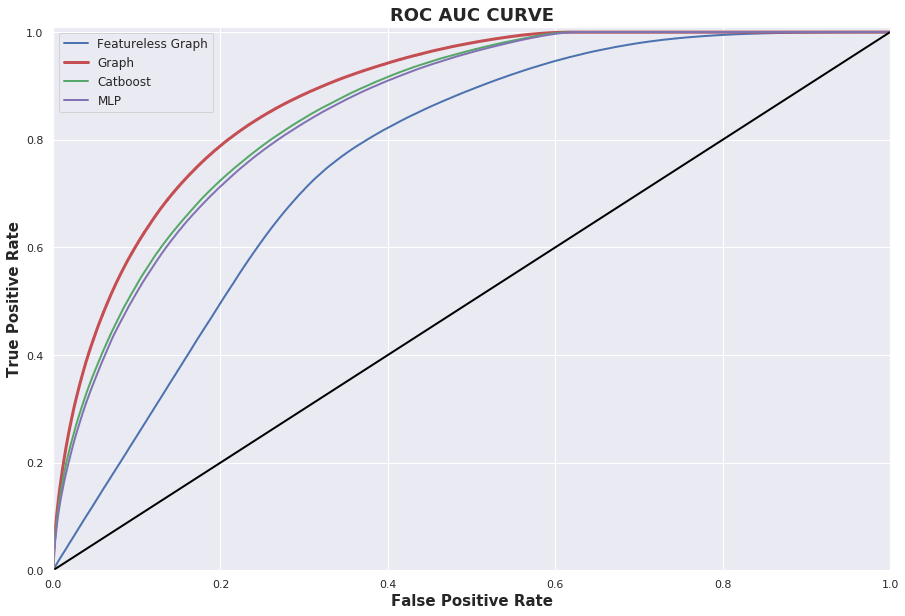

In [188]:
# calculate roc curves
from sklearn.metrics import roc_curve
from numpy import save, load,savetxt, loadtxt, savez_compressed
import matplotlib.pyplot as plt

fpr_RGCN_v1, tpr_RGCN_v1, _ = roc_curve(graph_test_df_v1["target"].values,  graph_test_df_v1["logit"].values)
fpr_RGCN_v2, tpr_RGCN_v2, _ = roc_curve(graph_test_df_v2["target"].values,  graph_test_df_v2["logit"].values)
fpr_Catboost, tpr_Catboost, _ = roc_curve(catboost_test_df["target"].values,  catboost_test_df["logit"].values)
fpr_mlp, tpr_mlp, _ = roc_curve(mlp_test_df["target"].values,  mlp_test_df["logit"].values)

# plot the roc curve for the model
fig = plt.subplots(figsize =(15, 10))
plt.plot(fpr_RGCN_v1, tpr_RGCN_v1, linestyle='solid', label='Featureless Graph', color ='b', linewidth=2)
plt.plot(fpr_RGCN_v2, tpr_RGCN_v2, linestyle='solid', label='Graph', color ='r', linewidth=3)
plt.plot(fpr_Catboost, tpr_Catboost, linestyle='solid', label='Catboost', color ='g', linewidth=2)
plt.plot(fpr_mlp, tpr_mlp, linestyle='solid', label='MLP', color ='m', linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='solid', color ='black', linewidth=2)
# axis labels
plt.xlabel('False Positive Rate', fontweight ='bold',fontsize=15)
plt.ylabel('True Positive Rate', fontweight ='bold',fontsize=15)
plt.title('ROC AUC CURVE', fontweight ='bold',fontsize=18)

plt.xlim([0, 1])
plt.ylim([0, 1.01])
# show the legend
plt.legend(fontsize="medium")
# show the plot
plt.show()

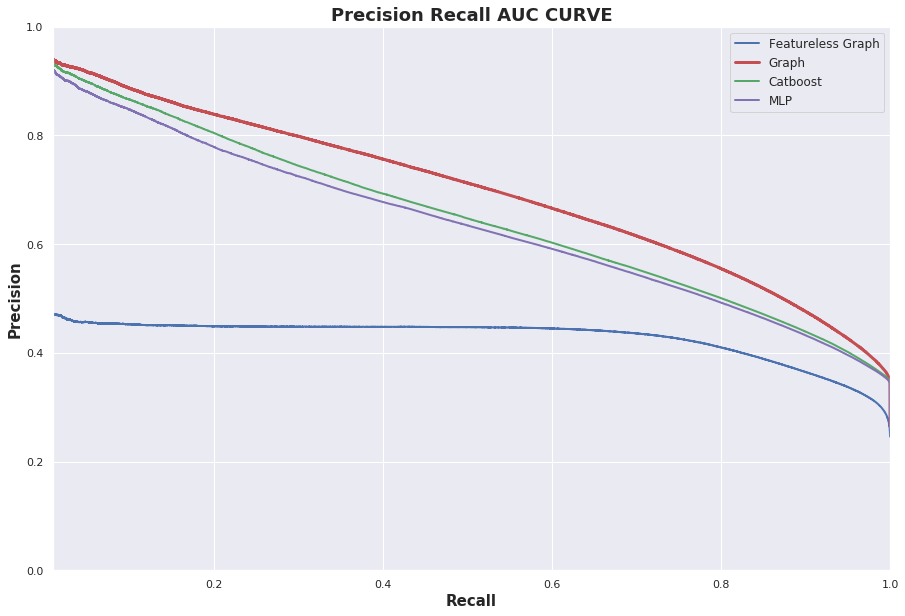

In [183]:
# calculate precision-recall curves
from sklearn.metrics import precision_recall_curve
from numpy import save, load,savetxt, loadtxt, savez_compressed
import matplotlib.pyplot as plt

prec_RGCN_v1, recall_RGCN_v1, _ = precision_recall_curve(graph_test_df_v1["target"].values,  graph_test_df_v1["logit"].values)
prec_RGCN_v2, recall_RGCN_v2, _ = precision_recall_curve(graph_test_df_v2["target"].values,  graph_test_df_v2["logit"].values)
prec_Catboost, recall_Catboost, _ = precision_recall_curve(catboost_test_df["target"].values,  catboost_test_df["logit"].values)
prec_mlp, recall_mlp, _ = precision_recall_curve(mlp_test_df["target"].values,  mlp_test_df["logit"].values)

fig = plt.subplots(figsize =(15, 10))

plt.plot(recall_RGCN_v1, prec_RGCN_v1, linestyle='solid', label='Featureless Graph', color ='b', linewidth=2)
plt.plot(recall_RGCN_v2, prec_RGCN_v2, linestyle='solid', label='Graph', color ='r', linewidth=3)
plt.plot(recall_Catboost, prec_Catboost, linestyle='solid', label='Catboost', color ='g', linewidth=2)
plt.plot(recall_mlp, prec_mlp, linestyle='solid', label='MLP', color ='m', linewidth=2)
# plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='random model', color ='black', linewidth=2)

# axis labels
plt.xlabel('Recall', fontweight ='bold',fontsize=15)
plt.ylabel('Precision', fontweight ='bold',fontsize=15)
plt.title('Precision Recall AUC CURVE', fontweight ='bold',fontsize=18)

plt.xlim([0.01, 1])
plt.ylim([0, 1])
# show the legend
plt.legend(fontsize="medium")
# show the plot
plt.show()

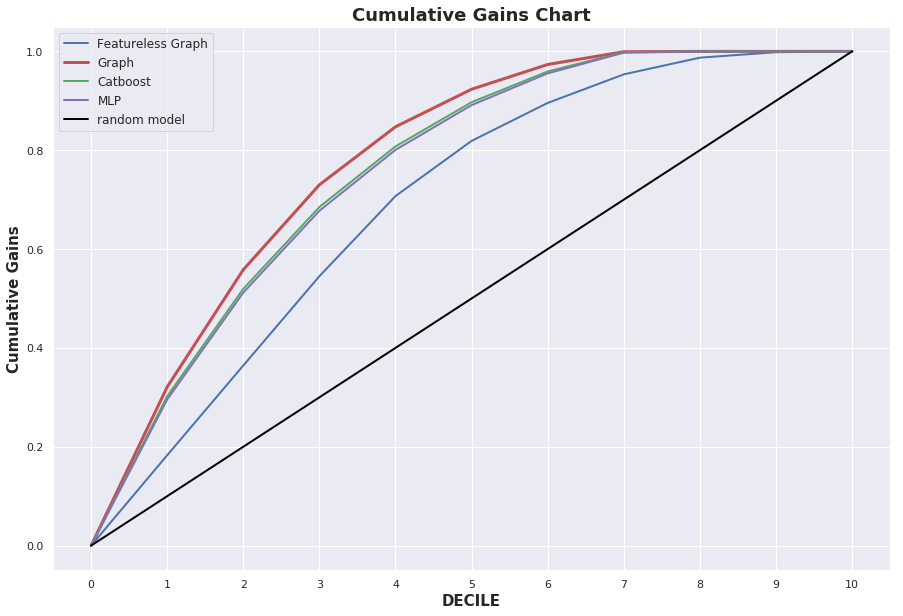

In [184]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=DF2.actual_label.sum()/DF.actual_label.sum()
    return gain

topk=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

gain_RGCN_v1 = lift_gain_eval(graph_test_df_v1["logit"].values, graph_test_df_v1["target"].values, topk)
gain_RGCN_v2 = lift_gain_eval(graph_test_df_v2["logit"].values, graph_test_df_v2["target"].values, topk)
gain_Catboost = lift_gain_eval(catboost_test_df["logit"].values, catboost_test_df["target"].values, topk)
gain_mlp = lift_gain_eval(mlp_test_df["logit"].values, mlp_test_df["target"].values, topk)

Decile=list(gain_RGCN_v1.keys())

gain_RGCN_v1=[gain_RGCN_v1[x] for x in Decile]
gain_RGCN_v2=[gain_RGCN_v2[x] for x in Decile]
gain_Catboost=[gain_Catboost[x] for x in Decile]
gain_mlp=[gain_mlp[x] for x in Decile]

gain_RGCN_v1.insert(0,0)
gain_RGCN_v2.insert(0,0)
gain_Catboost.insert(0,0)
gain_mlp.insert(0,0)

Decile=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
# plot the roc curve for the model
fig = plt.subplots(figsize =(15, 10))
plt.plot(Decile, gain_RGCN_v1, linestyle='solid', label='Featureless Graph', color ='b', linewidth=2)
plt.plot(Decile, gain_RGCN_v2, linestyle='solid', label='Graph', color ='r', linewidth=3)
plt.plot(Decile, gain_Catboost, linestyle='solid', label='Catboost', color ='g', linewidth=2)
plt.plot(Decile, gain_mlp, linestyle='solid', label='MLP', color ='m', linewidth=2)

plt.plot([0, 10], [0, 1], linestyle='solid', label='random model', color ='black', linewidth=2)
# axis labels
plt.xlabel('DECILE', fontweight ='bold',fontsize=15)
plt.ylabel('Cumulative Gains', fontweight ='bold',fontsize=15)
plt.title('Cumulative Gains Chart', fontweight ='bold',fontsize=18)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10])
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# show the legend
plt.legend(fontsize="medium")
# show the plot
plt.show()

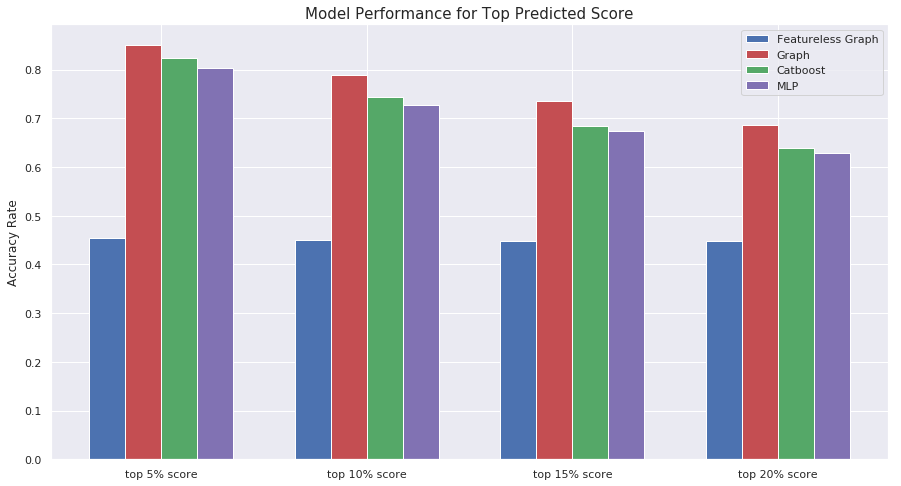

In [189]:
import math
def response_rate_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    response_rate={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        response_rate[str(int(p*100))+"%"]=DF2.actual_label.sum()/DF2.shape[0]
    return response_rate

topk=[0.05,0.1,0.15,0.2]
response_RGCN_v1 = response_rate_eval(graph_test_df_v1["logit"], graph_test_df_v1["target"], topk)
response_RGCN_v2 = response_rate_eval(graph_test_df_v2["logit"], graph_test_df_v2["target"], topk)
response_Catboost = response_rate_eval(catboost_test_df["logit"], catboost_test_df["target"], topk)
response_MLP = response_rate_eval(mlp_test_df["logit"], mlp_test_df["target"], topk)

Decile=list(response_RGCN_v1.keys())

response_RGCN_v1=[response_RGCN_v1[x] for x in Decile]
response_RGCN_v2=[response_RGCN_v2[x] for x in Decile]
response_Catboost=[response_Catboost[x] for x in Decile]
response_MLP=[response_MLP[x] for x in Decile]

from matplotlib import pyplot as plt


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

    ax.set_ylabel('Accuracy Rate')
    ind=np.arange(len(data[list(data.keys())[0]]))
    ax.set_xticks(ind)
    ax.set_xticklabels( ('top 5% score', 'top 10% score', 'top 15% score', 'top 20% score') )
    ax.set_title("Model Performance for Top Predicted Score",fontsize=15)


if __name__ == "__main__":
    # Usage example:
    data = {
        "Featureless Graph": response_RGCN_v1,
        "Graph": response_RGCN_v2,
        "Catboost": response_Catboost,
        "MLP": response_MLP
    }

    fig, ax = plt.subplots()
    CL=['b', 'r', 'g', 'm', 'y', 'darkorange', 'lime', 'grey','gold','bisque', 'lightseagreen', 'purple']
    bar_plot(ax, data, colors=CL,total_width=.7, single_width=1)
#     plt.xlim([0, 1])
#     plt.ylim([0.5, 1])
    plt.show()

## profile analysis 

In [117]:
import torch as th
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns

def topk_df(DF,top_list):
    DF.sort_values(by=["logit"],inplace=True)
    logits=DF["logit"].values
    n=int(DF.shape[0]*top_list)
    _,idx=th.from_numpy(logits).squeeze().topk(n)
    idx=idx.tolist()
    df=DF.iloc[idx,:]
    return df

def overlap(arg_1,arg_2):
    look_idx=pd.DataFrame({"idx":arg_1})
    query_idx=pd.DataFrame({"idx":arg_2})
    
    look_idx=look_idx.set_index(['idx']).index
    query_idx=query_idx.set_index(['idx']).index
    
    mask=query_idx.isin(look_idx)
    
    return mask, np.sum(mask), np.sum(mask)/mask.shape[0]

def profile_analysis(graph_test_df_v1, graph_test_df_v2, catboost_test_df, mlp_test_df,toplist):
    test_graph_v1=topk_df(graph_test_df_v1,toplist)['usaanr'].values
    test_graph_v2=topk_df(graph_test_df_v2,toplist)['usaanr'].values
    test_catboost=topk_df(catboost_test_df,toplist)['usaanr'].values
    test_mlp=topk_df(mlp_test_df,toplist)['usaanr'].values
    
    _, overlap_graph_num, overlap_graph_perc=overlap(test_graph_v1,test_graph_v2)
    _, overlap_graph_cat_num_v1, overlap_graph_cat_perc_v1=overlap(test_graph_v1,test_catboost)
    _, overlap_graph_cat_num_v2, overlap_graph_cat_perc_v2=overlap(test_graph_v2,test_catboost)
    _, overlap_graph_mlp_num_v1, overlap_graph_mlp_perc_v1=overlap(test_graph_v1,test_mlp)
    _, overlap_graph_mlp_num_v2, overlap_graph_mlp_perc_v2=overlap(test_graph_v2,test_mlp)
    _, overlap_cat_mlp_num, overlap_cat_mlp_perc=overlap(test_catboost,test_mlp)
    
    print()
    print(f"Top {str(int(toplist*100))}% scored members overlapping between different model")
    print()
    data={}
    data['model_type']=["Graph vs Graph Featureless", "Graph vs MLP", "Graph vs CatBoost", "CatBoost vs MLP"]
    data['# of Overlapping']=[overlap_graph_num, overlap_graph_mlp_num_v2,  overlap_graph_cat_num_v2, overlap_cat_mlp_num]
    data['% of Overlapping']=[overlap_graph_perc, overlap_graph_mlp_perc_v2, overlap_graph_cat_perc_v2, overlap_cat_mlp_perc]
    df=pd.DataFrame(data)
#     df.style.format({'# of Overlapping':"{:,}", '% of Overlapping':"{:.2%}"})
    return df


In [35]:
df=profile_analysis(graph_test_df_v1, graph_test_df_v2, catboost_test_df, mlp_test_df,toplist=0.05)
df.style.format({'# of Overlapping':"{:,}", '% of Overlapping':"{:.2%}"})


Top 5% scored members overlapping between different model



,model_type,# of Overlapping,% of Overlapping
0,Graph vs Graph Featureless,"16,904",13.17%
1,Graph vs MLP,"91,536",71.32%
2,Graph vs CatBoost,"92,119",71.78%
3,CatBoost vs MLP,"107,519",83.78%


In [37]:
df=profile_analysis(graph_test_df_v1, graph_test_df_v2, catboost_test_df, mlp_test_df,toplist=0.10)
df.style.format({'# of Overlapping':"{:,}", '% of Overlapping':"{:.2%}"})


Top 10% scored members overlapping between different model



,model_type,# of Overlapping,% of Overlapping
0,Graph vs Graph Featureless,"62,456",24.33%
1,Graph vs MLP,"180,375",70.27%
2,Graph vs CatBoost,"185,376",72.22%
3,CatBoost vs MLP,"221,564",86.32%


In [38]:
df=profile_analysis(graph_test_df_v1, graph_test_df_v2, catboost_test_df, mlp_test_df,toplist=0.15)
df.style.format({'# of Overlapping':"{:,}", '% of Overlapping':"{:.2%}"})


Top 15% scored members overlapping between different model



,model_type,# of Overlapping,% of Overlapping
0,Graph vs Graph Featureless,"131,653",34.19%
1,Graph vs MLP,"284,820",73.97%
2,Graph vs CatBoost,"294,726",76.55%
3,CatBoost vs MLP,"337,447",87.64%


In [39]:
df=profile_analysis(graph_test_df_v1, graph_test_df_v2, catboost_test_df, mlp_test_df,toplist=0.20)
df.style.format({'# of Overlapping':"{:,}", '% of Overlapping':"{:.2%}"})


Top 20% scored members overlapping between different model



,model_type,# of Overlapping,% of Overlapping
0,Graph vs Graph Featureless,"223,185",43.47%
1,Graph vs MLP,"397,442",77.42%
2,Graph vs CatBoost,"408,324",79.54%
3,CatBoost vs MLP,"464,356",90.45%


In [168]:
graph_test_df_v1.head(2)

,usaanr,usaayr,AGE_BAND,ORIGEL,ELIG2,SEX,MARST,BRANCH,ENLPAYGD,MILST,MLIST_OrigStat,STATE,target,logit
2553367,17258845,83,0,19,5,2,2,0,17,0,2,0,0,-2.797929
1830186,9227869,75,5,19,5,2,2,0,17,0,2,56,0,-2.616275


In [141]:
toplist=0.1
graph_v1=topk_df(graph_test_df_v1,toplist)
graph_v2=topk_df(graph_test_df_v2,toplist)
catboost=topk_df(catboost_test_df,toplist)
mlp=topk_df(mlp_test_df,toplist)

catboost["AGE_BAND"]=catboost["AGE_BAND"].astype(int)
catboost["ELIG2"]=catboost["ELIG2"].astype(int)
catboost["SEX"]=catboost["SEX"].astype(int)
catboost["MILST"]=catboost["MILST"].astype(int)
catboost["MARST"]=catboost["MARST"].astype(int)

In [43]:
!hdfs dfs -get  /dz/dz_6295/disc.db/vertices_pickle  ~/vertices_pickle
vertices=pd.read_pickle(os.path.join("/home/ubuntu/",'vertices_pickle'))

In [45]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def revert_column_name(le,col):
    le.fit(vertices[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    return le_name_mapping

In [139]:
revert_column_name(le,"MARST")

{'0)DATA HAS NOT BEEN ASKED FOR': 0,
 '1)SINGLE': 1,
 '2)MARRIED': 2,
 '3)WIDOWED': 3,
 '4)SEPARATED': 4,
 '5)DIVORCED': 5,
 '6)DIVORCE PENDING': 6,
 '7)LEGAL SEPARATION': 7,
 '8)NONE-DATA DOES NOT APPLY': 8,
 '9)CUST REFUSED TO PROVIDE DATA': 9}

In [142]:
MARST_name={"MARST":{0:"Data Not Asked For",1:"SINGLE",2:"MARRIED",3:"WIDOWED",4:"SEPARATED",5:"DIVORCED",6:"DIVORCE PENDING",7:"LEGAL SEPARATION",8:"NOT APPLY",9:"REFUSED TO ANSWER"}}
graph_v1.replace(MARST_name,inplace=True)
graph_v2.replace(MARST_name,inplace=True)
catboost.replace(MARST_name,inplace=True)
mlp.replace(MARST_name,inplace=True)

sex_name={"SEX":{0:"Data Not Asked For",1:"Male",2:"Female",3:"Data does not apply",4:"Unknown"}}
graph_v1.replace(sex_name,inplace=True)
graph_v2.replace(sex_name,inplace=True)
catboost.replace(sex_name,inplace=True)
mlp.replace(sex_name,inplace=True)

ELIG2_name={"ELIG2":{0:"OFFICER",1:"ENLISTED",2:"NCO",3:"ASSOCIATE",4:"OTHER ELIG",5:"FAMILY"}}
graph_v1.replace(ELIG2_name,inplace=True)
graph_v2.replace(ELIG2_name,inplace=True)
catboost.replace(ELIG2_name,inplace=True)
mlp.replace(ELIG2_name,inplace=True)

AGE_name={"AGE_BAND":{0:"30 or less",1:"31 to 40",2:"41 to 50",3:"51 to 60",4:"61 to 70",5:"71 to 80",6:"1 or more"}}
graph_v1.replace(AGE_name,inplace=True)
graph_v2.replace(AGE_name,inplace=True)
catboost.replace(AGE_name,inplace=True)
mlp.replace(AGE_name,inplace=True)

MILST_name={"MILST":{0:"NOT ASKED FOR",1:"ACTIVE DUTY",2:"RETIRED",3:"INACTIVE RESERVE",4:"NOT APPLY",5:"PRE-COMMISSIONED",6:"SEPARATED",7:"ACTIVE RESERVE"}}
graph_v1.replace(MILST_name,inplace=True)
graph_v2.replace(MILST_name,inplace=True)
catboost.replace(MILST_name,inplace=True)
mlp.replace(MILST_name,inplace=True)

TARGET_name={"target":{0:"No Auto",1:"Yes Auto"}}
graph_v1.replace(TARGET_name,inplace=True)
graph_v2.replace(TARGET_name,inplace=True)
catboost.replace(TARGET_name,inplace=True)
mlp.replace(TARGET_name,inplace=True)

/usr/local/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:6704: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


In [143]:
def myfunc(graph_v1,graph_v2,catboost,mlp,feat):
    graph_v1=graph_v1.loc[:,feat].reset_index(drop=True)
    graph_v2=graph_v2.loc[:,feat].reset_index(drop=True)
    catboost=catboost.loc[:,feat].reset_index(drop=True)
    mlp=mlp.loc[:,feat].reset_index(drop=True)
    graph_v1['type']="Featureless Graph"
    graph_v2['type']="Graph"
    catboost['type']="catboost"
    mlp['type']="MLP"
    DF=graph_v1.copy()
    DF=DF.append(graph_v2)
    DF=DF.append(catboost)
    DF=DF.append(mlp)
    
    return DF

In [146]:
feat=["SEX","ELIG2","AGE_BAND","MILST","MARST","target"]
DF=myfunc(graph_v1,graph_v2,catboost,mlp,feat)

Text(0.5, 0, 'Count')

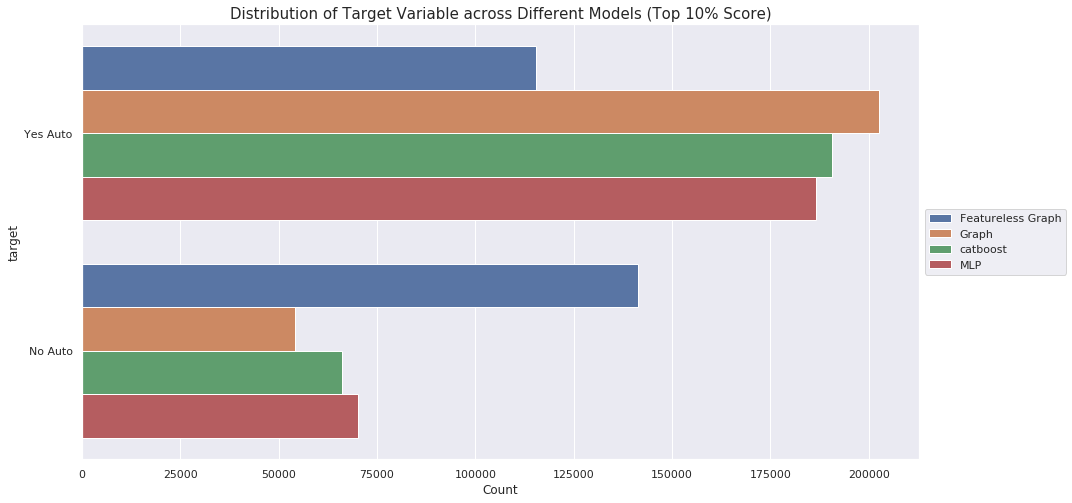

In [147]:
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.countplot(y="target", hue='type', data=DF,  hue_order=['Featureless Graph','Graph','catboost','MLP'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Distribution of Target Variable across Different Models (Top 10% Score)",fontsize=15)
ax.set_xlabel('Count')

Text(0.5, 0, 'Count')

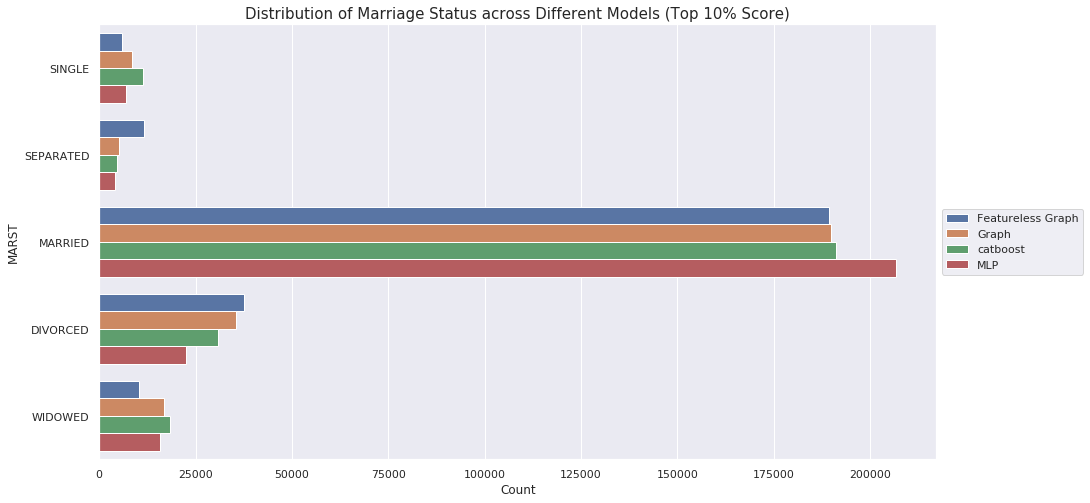

In [153]:
DF2=DF[~DF['MARST'].isin(["Data Not Asked For","LEGAL SEPARATION","DIVORCE PENDING","REFUSED TO ANSWER","NOT APPLY"])]
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.countplot(y='MARST', hue='type', data=DF2, order=['SINGLE', 'SEPARATED', 'MARRIED', 'DIVORCED', 'WIDOWED'], \
                   hue_order=['Featureless Graph','Graph','catboost','MLP'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Distribution of Marriage Status across Different Models (Top 10% Score)",fontsize=15)
ax.set_xlabel('Count')

Text(0.5, 0, 'Count')

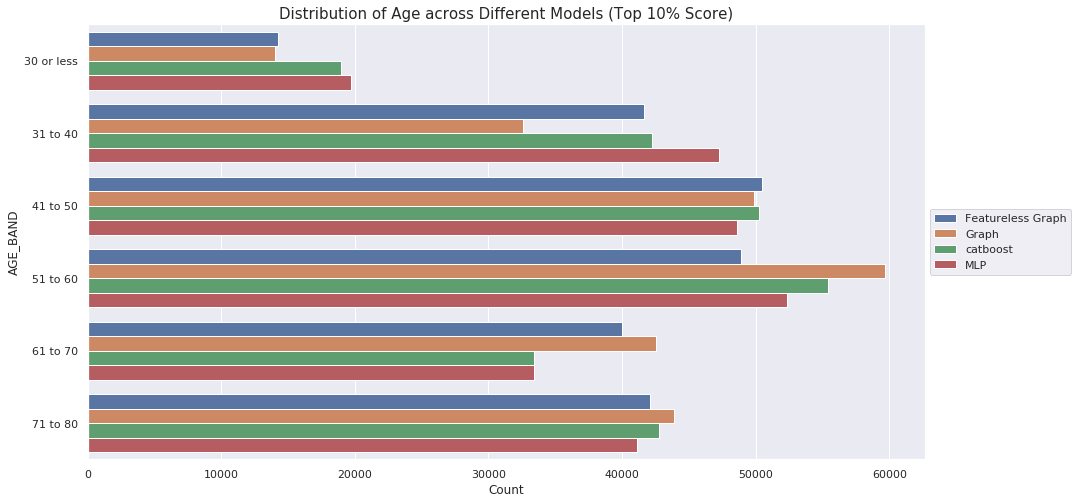

In [135]:
DF2=DF[~DF['AGE_BAND'].isin(["81 or more"])]
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.countplot(y='AGE_BAND', hue='type', data=DF2, order=["30 or less", "31 to 40", "41 to 50", "51 to 60","61 to 70","71 to 80"], hue_order=['Featureless Graph','Graph','catboost','MLP'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Distribution of Age across Different Models (Top 10% Score)",fontsize=15)
ax.set_xlabel('Count')

Text(0.5, 0, 'Count')

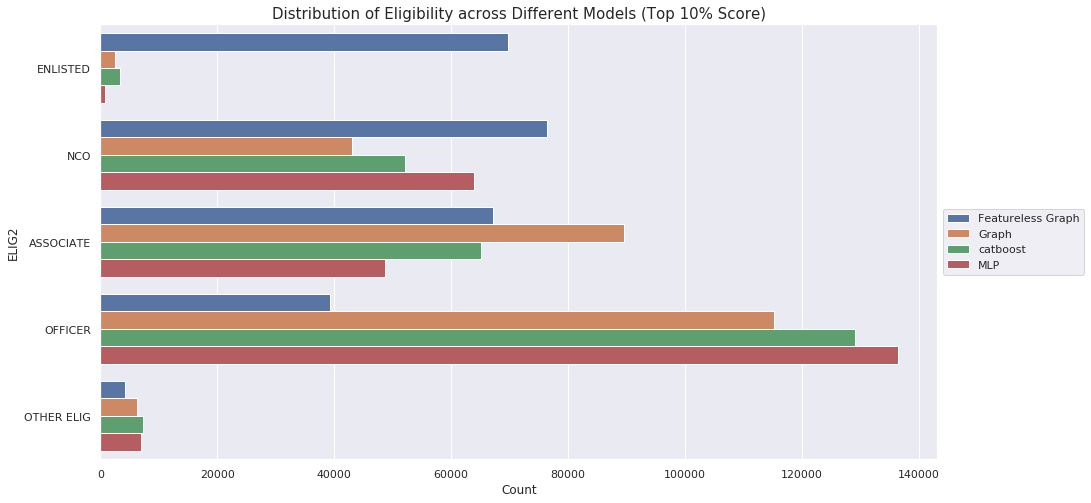

In [134]:
DF2=DF[~DF['ELIG2'].isin(['FAMILY'])]
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.countplot(y='ELIG2', hue='type', data=DF2, order=['ENLISTED', 'NCO', 'ASSOCIATE', 'OFFICER', 'OTHER ELIG'], hue_order=['Featureless Graph','Graph','catboost','MLP'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Distribution of Eligibility across Different Models (Top 10% Score)",fontsize=15)
ax.set_xlabel('Count')

Text(0.5, 0, 'Count')

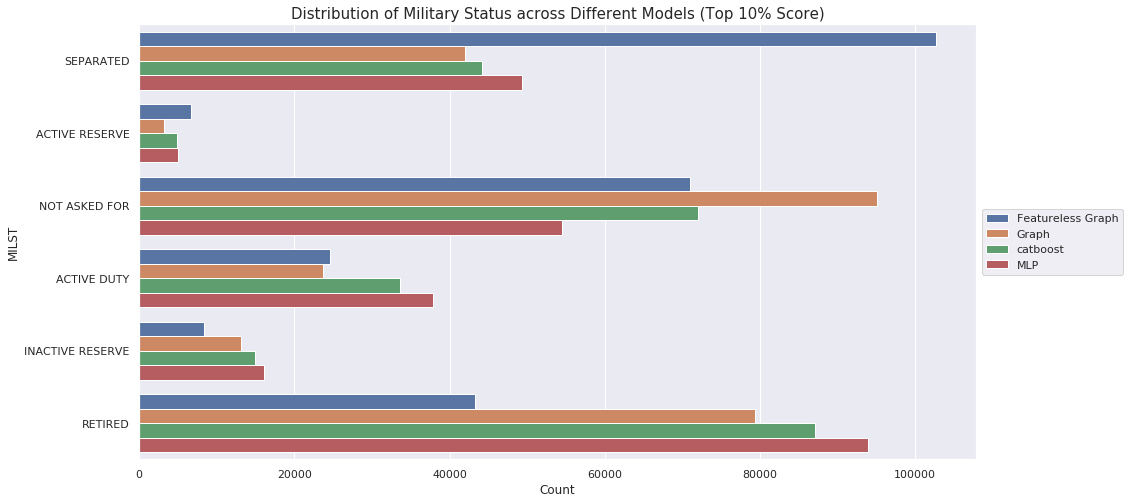

In [133]:
DF2=DF[~DF['SEX'].isin(['NOT APPLY', 'PRE-COMMISSIONED'])]

sns.set(rc={'figure.figsize':(15,8)})
ax = sns.countplot(y='MILST', hue='type', data=DF, order=['SEPARATED', 'ACTIVE RESERVE', 'NOT ASKED FOR', 'ACTIVE DUTY','INACTIVE RESERVE', 'RETIRED'], \
                   hue_order=['Featureless Graph','Graph','catboost','MLP'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Distribution of Military Status across Different Models (Top 10% Score)",fontsize=15)
ax.set_xlabel('Count')

Text(0.5, 0, 'Count')

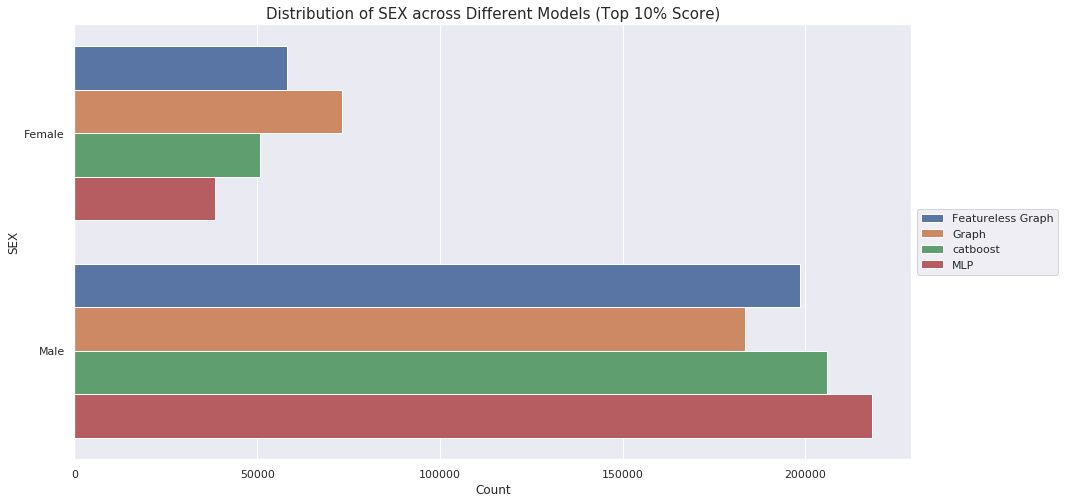

In [132]:
DF2=DF[DF['SEX'].isin(['Female', 'Male'])]
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.countplot(y='SEX', hue='type', data=DF2, order=['Female', 'Male'], hue_order=['Featureless Graph','Graph','catboost','MLP'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Distribution of SEX across Different Models (Top 10% Score)",fontsize=15)
ax.set_xlabel('Count')

## Is model performance robust when changing the size of subgraph ?

In [ ]:
# import matplotlib.pyplot as plt
# test_pct=["90%","80%","70%","60%","50%","40%","30%","20%","10%"]
# graph_Accuracy=[0.7561,0.7769,0.7888,0.7897,0.7621,0.7744,0.7366,0.7794,0.7647]
# catboost_Accuracy=[0.7421,0.7428,0.7434,0.7425,0.7426,0.7427,0.7436,0.7429,0.7435]
# MLP_Accuracy=[0.7418,0.7384,0.7379,0.7282,0.7353,0.7324,0.7212,0.7371,0.7360]

# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,6))
# ax1.plot(test_pct, graph_Accuracy, label = "Graph",color='r',marker='s', linestyle="-", linewidth=2)
# ax1.plot(test_pct, catboost_Accuracy, label = "CatBoost",color='b',marker='h', linestyle="--", linewidth=2)
# ax1.plot(test_pct, MLP_Accuracy, label = "MLP",color='m',marker='d', linestyle="-.", linewidth=2)
# ax1.legend()
# ax1.set_title("Accuracy (Training)",fontsize=20)
# ax1.set_xlabel("Proportion of Training Dataset",fontsize=12)
# ax1.set_ylabel("Accuracy",fontsize=12)

# test_pct=["10%","20%","30%","40%","50%","60%","70%","80%","90%"]
# graph_Accuracy=[0.7561,0.7768,0.7887,0.7896,0.7621,0.7744,0.7366,0.7794,0.7647]
# catboost_Accuracy=[0.7422,0.7428,0.7433,0.7424,0.7426,0.7427,0.7436,0.7429,0.7435]
# MLP_Accuracy=[0.7423,0.7386,0.7378,0.7282,0.7353,0.7324,0.7212,0.7371,0.7360]

# ax2.plot(test_pct, graph_Accuracy, label = "Graph",color='r',marker='s', linestyle="-", linewidth=2)
# ax2.plot(test_pct, catboost_Accuracy, label = "CatBoost",color='b',marker='h', linestyle="--", linewidth=2)
# ax2.plot(test_pct, MLP_Accuracy, label = "MLP",color='m',marker='d', linestyle="-.", linewidth=2)
# ax2.legend()
# ax2.set_title("Accuracy (Test)",fontsize=20)
# ax2.set_xlabel("Proportion of Test Dataset",fontsize=12)
# ax2.set_ylabel("Accuracy",fontsize=12)
# plt.show()

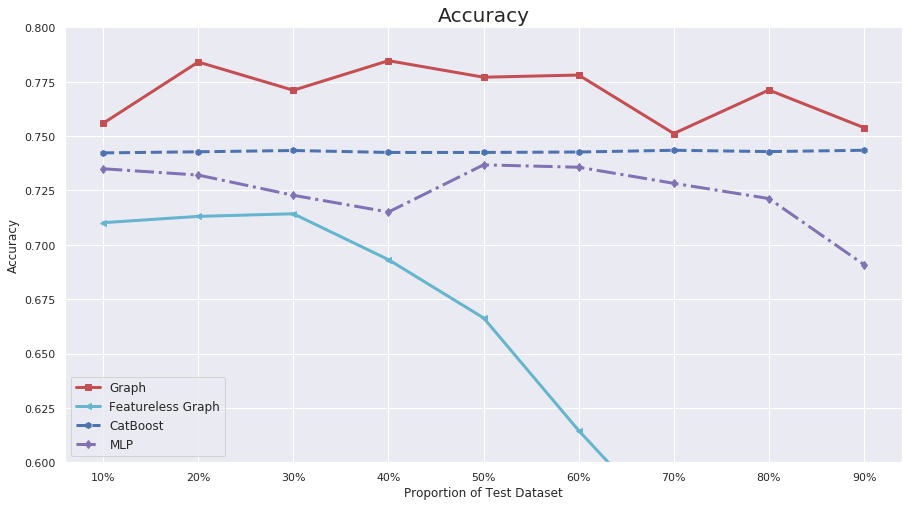

In [171]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
test_pct=["10%","20%","30%","40%","50%","60%","70%","80%","90%"]
graph_Accuracy=[0.7559,0.7841,0.7711,0.7847,0.7771,0.7781,0.7512,0.7712,0.7539]
graph_featless_Accuracy=[0.7102,0.7131,0.7143,0.6932,0.6664,0.6146,0.5676,0.5285,0.4951]
catboost_Accuracy=[0.7423,0.7428,0.7434,0.7425,0.7425,0.7427,0.7435,0.7429,0.7435]
MLP_Accuracy=[0.7350,0.7321,0.7228,0.7151,0.7368,0.7357,0.7283,0.7213,0.6909]
plt.plot(test_pct, graph_Accuracy, label = "Graph",color='r',marker='s', linestyle="-", linewidth=3)
plt.plot(test_pct, graph_featless_Accuracy, label = "Featureless Graph",color='c',marker='<', linestyle="-", linewidth=3)
plt.plot(test_pct, catboost_Accuracy, label = "CatBoost",color='b',marker='h', linestyle="--", linewidth=3)
plt.plot(test_pct, MLP_Accuracy, label = "MLP",color='m',marker='d', linestyle="-.", linewidth=3)
plt.legend(fontsize=12)
plt.title("Accuracy",fontsize=20)
plt.xlabel("Proportion of Test Dataset",fontsize=12)
plt.ylabel("Accuracy",fontsize=12)
plt.ylim(0.60,0.8)
plt.show()

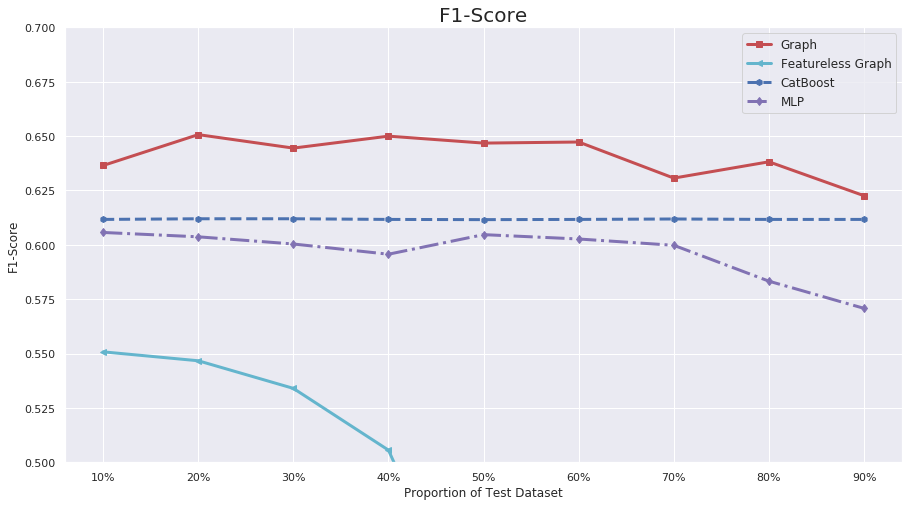

In [172]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
test_pct=["10%","20%","30%","40%","50%","60%","70%","80%","90%"]
graph_F1=[0.6365,0.6507,0.6445,0.6500,0.6468,0.6473,0.6307,0.6382,0.6226]
graph_featless_F1=[0.5508,0.5467,0.5340,0.5056,0.4085,0.3398,0.3444,0.3413,0.3425]
catboost_F1=[0.6117,0.6120,0.6120,0.6117,0.6116,0.6117,0.6119,0.6117,0.6117]
MLP_F1=[0.6057,0.6037,0.6004,0.5957,0.6047,0.6027,0.5998,0.5833,0.5708]
plt.plot(test_pct, graph_F1, label = "Graph",color='r',marker='s', linestyle="-", linewidth=3)
plt.plot(test_pct, graph_featless_F1, label = "Featureless Graph",color='c',marker='<', linestyle="-", linewidth=3)
plt.plot(test_pct, catboost_F1, label = "CatBoost",color='b',marker='h', linestyle="--", linewidth=3)
plt.plot(test_pct, MLP_F1, label = "MLP",color='m',marker='d', linestyle="-.", linewidth=3)
plt.legend(fontsize=12)
plt.title("F1-Score",fontsize=20)
plt.xlabel("Proportion of Test Dataset",fontsize=12)
plt.ylabel("F1-Score",fontsize=12)
plt.ylim(0.50,0.70)
plt.show()

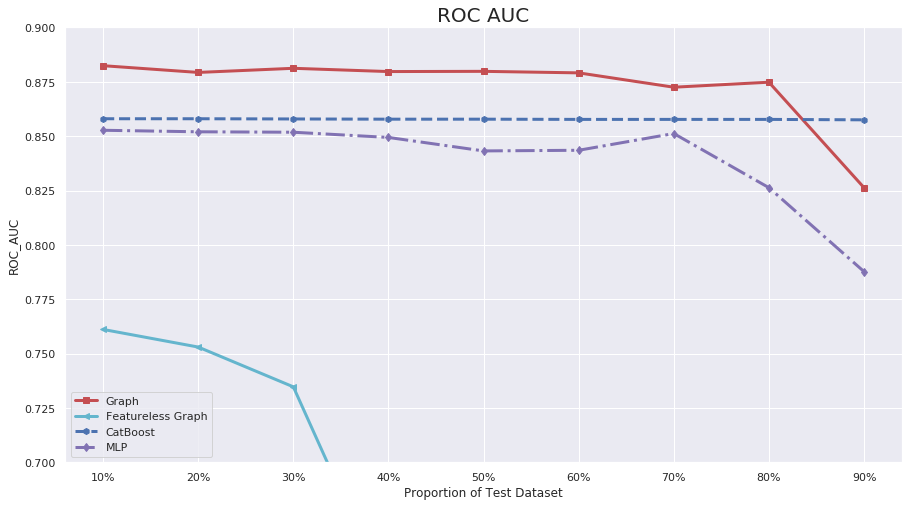

In [173]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
test_pct=["10%","20%","30%","40%","50%","60%","70%","80%","90%"]
graph_ROC_AUC=[0.8824,0.8793,0.8812,0.8797,0.8798,0.8791,0.8725,0.8748,0.8263]
graph_featless_ROC_AUC=[0.7611,0.7530,0.7347,0.6375,0.5297,0.5063,0.5037,0.5008,0.4995]
catboost_ROC_AUC=[0.8580,0.8580,0.8579,0.8578,0.8578,0.8577,0.8577,0.8577,0.8575]
MLP_ROC_AUC=[0.8527,0.8520,0.8518,0.8494,0.8432,0.8435,0.8512,0.8263,0.7877]
plt.plot(test_pct, graph_ROC_AUC, label = "Graph",color='r',marker='s', linestyle="-", linewidth=3)
plt.plot(test_pct, graph_featless_ROC_AUC, label = "Featureless Graph",color='c',marker='<', linestyle="-", linewidth=3)
plt.plot(test_pct, catboost_ROC_AUC, label = "CatBoost",color='b',marker='h', linestyle="--", linewidth=3)
plt.plot(test_pct, MLP_ROC_AUC, label = "MLP",color='m',marker='d', linestyle="-.", linewidth=3)
plt.legend()
plt.title("ROC AUC",fontsize=20)
plt.xlabel("Proportion of Test Dataset",fontsize=12)
plt.ylabel("ROC_AUC",fontsize=12)
plt.ylim(0.70,0.90)
plt.show()

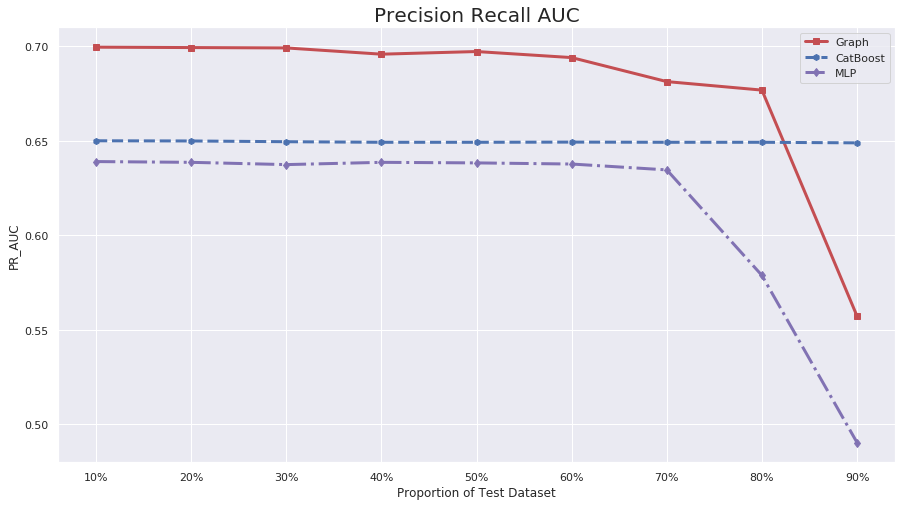

In [174]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
test_pct=["10%","20%","30%","40%","50%","60%","70%","80%","90%"]
graph_PR_AUC=[0.6995,0.6993,0.6991,0.6958,0.6972,0.6940,0.6813,0.6768,0.5573]
catboost_PR_AUC=[0.6500,0.6499,0.6495,0.6492,0.6492,0.6493,0.6492,0.6492,0.6489]
MLP_PR_AUC=[0.6390,0.6386,0.6374,0.6386,0.6383,0.6377,0.6346,0.5788,0.4904]
plt.plot(test_pct, graph_PR_AUC, label = "Graph",color='r',marker='s', linestyle="-", linewidth=3)
plt.plot(test_pct, catboost_PR_AUC, label = "CatBoost",color='b',marker='h', linestyle="--", linewidth=3)
plt.plot(test_pct, MLP_PR_AUC, label = "MLP",color='m',marker='d', linestyle="-.", linewidth=3)
plt.legend()
plt.title("Precision Recall AUC",fontsize=20)
plt.xlabel("Proportion of Test Dataset",fontsize=12)
plt.ylabel("PR_AUC",fontsize=12)
plt.show()

### Inductive Learning

<img src="Inductive_Learning.PNG" alt="drawing" width="750"/>

### Training Set
----------------------------------------------------------------------------------------------------
model                         catboost            MLP                 Graph               
                                                                                          
% test                        10.0%               10.0%               10.0%               
nb_example                    21,870,492          21,870,492          21,870,492          
true_prediction               16,248,611          16,542,062          16,741,888          
false_prediction              5,621,881           5,328,430           5,128,604           
accuracy                      74.29%              75.64%              76.55%              
precision                     49.35%              54.23%              52.10%              
recall                        82.28%              20.38%              84.58%              
f1_score                      61.70%              29.63%              64.48%              
AUC                           85.68%              76.45%              87.75%              
pr_auc                        65.43%              46.92%              69.37%              

### Test Set
----------------------------------------------------------------------------------------------------
model                         catboost            MLP                 Graph               
                                                                                          
% test                        10.0%               10.0%               10.0%               
nb_example                    3,798,012           3,798,012           3,798,012           
true_prediction               2,866,482           2,998,226           2,872,631           
false_prediction              931,530             799,786             925,381             
accuracy                      75.47%              78.94%              75.64%              
precision                     45.60%              50.89%              46.03%              
recall                        80.62%              22.45%              85.70%              
f1_score                      58.25%              31.15%              59.89%              
AUC                           86.27%              77.94%              88.16%              
pr_auc                        61.91%              43.74%              65.92%  